### Prerequisites (Deps)

In [ ]:
# install on fresh conda environment
!conda install pytorch-nightly-cpu -c pytorch -y
!conda install -c conda-forge matplotlib -y

!pip install opencv-python
!pip install -U pure-python-adb
!pip install keras-maskrcnn
!pip install keras-retinanet
!pip install pycocotools
!pip install future

### Prerequisites (Env)


1. ADB installed on PC (ADB binary added to $PATH)

2. Android device with:
    
    
    -- dir
        -- data
        -- output
        -- model
            -- model_init.pb
            -- moel_predict.pb
        -- speed_benchmark (binary)
        
3. How to cook speed_benchmark:

    1. Clone PyTorch 1.0 repo
    ```git clone --recursive https://github.com/pytorch/pytorch.git
    cd pytorch```

    2. Optional: update QNNPACK submodule to latest revision
    ```git submodule update --remote third_party/QNNPACK```

    3. Build Caffe2 (including binaries) for Android, and push to device
    
    ```scripts/build_android.sh -DANDROID_ABI=arm64-v8a -DANDROID_TOOLCHAIN=clang -DBUILD_BINARY=ON```
    ```adb push build_android/bin/speed_benchmark /data/local/tmp/speed_benchmark```

In [1]:
%matplotlib inline

from code.postprocess import postprocess
from code.preprocess import preprocess

from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.colors import label_color
import cv2

from adb.client import Client as AdbClient
import os
import time
import matplotlib.pyplot as plt

### Start  ADB server and connect to device

In [2]:
cmd = 'adb start-server'
os.system(cmd)

# Default is "127.0.0.1" and 5037
client = AdbClient(host="127.0.0.1", port=5037)
devices = client.devices()
device = devices[0]

### Preprocess data on PC and upload on Android

In [3]:
# Data must exist on your PC
min_size = 320
max_size = 320
image_file = "./data/2.jpg"
blobs_dir_path = "./protos/"
preprocess(image_file, blobs_dir_path, min_size, max_size)

device.push('./protos/im_info', '/data/local/tmp/m2go/data/im_info.pb')
device.push('./protos/data', '/data/local/tmp/m2go/data/data.pb')

### Infer via benchmark

In [4]:
cmd = (
    '/data/local/tmp/m2go/speed_benchmark',
    '--net /data/local/tmp/m2go/m2go_fp32/predict_net.pb',
    '--init_net /data/local/tmp/m2go/m2go_fp32/init_net.pb',
#     "--input_dims '1,3,180,180;1,3'",
    "--input 'data,im_info'",
    "--input_file '/data/local/tmp/m2go/data/data.pb,/data/local/tmp/m2go/data/im_info.pb'",
    "--input_type 'float;float'",
    '--warmup 1 --iter 1',
#     "--caffe2_print_blob_sizes_at_exit true",
#     "--run_individual true",
    "--output '*'",
    "--output_folder /data/local/tmp/m2go/output",
)

output = device.shell(" ".join(cmd))
print(output)

Starting benchmark.
Running warmup runs.
Main runs.
Main run finished. Milliseconds per iter: 742.901. Iters per second: 1.34607



### Download data from phone and postprocess

In [5]:
for item in ["class_nms", "score_nms", "bbox_nms", "mask_fcn_probs"]:
    device.pull('/data/local/tmp/m2go/output/{}'.format(item), './{}'.format(item))
    
seg = postprocess(image_file, '.')
boxes = seg['boxes'][:, :4].copy()
scores = seg['boxes'][:, 4]
labels = seg['classids']
masks = seg['masks']

### Draw results

processing time:  0.000152587890625


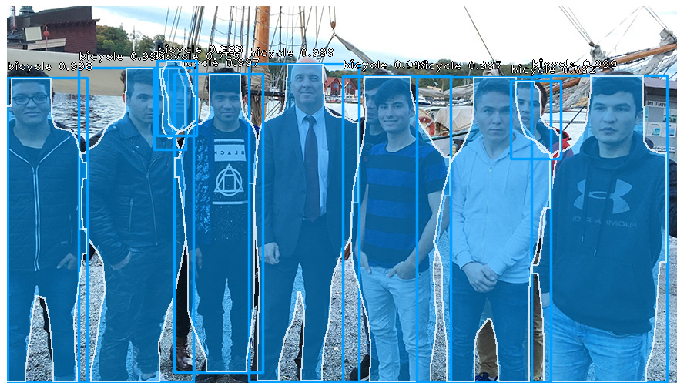

In [6]:
# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 
                   5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 
                   10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 
                   14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 
                   20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 
                   25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 
                   30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 
                   35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 
                   39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 
                   45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 
                   51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 
                   57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 
                   62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 
                   68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 
                   73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 
                   78: 'hair drier', 79: 'toothbrush'}

draw = cv2.imread(image_file)
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# process image
start = time.time()
print("processing time: ", time.time() - start)

# visualize detections
for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.3:
        break
    label = int(label)

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[label, :, :]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(draw)
plt.show()